In [1]:
%cd ..

/pub/hofmann-scratch/glanzillo/ded


In [2]:

import importlib
import json
import math
import os
import socket
import sys
import time


internal_path = os.path.abspath(os.path.join('.'))
sys.path.append(internal_path)
sys.path.append(internal_path + '/datasets')
sys.path.append(internal_path + '/utils')

import datetime
import uuid
from argparse import ArgumentParser

import setproctitle
import torch
import numpy as np
import pandas as pd 
import json


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
from matplotlib.collections import LineCollection



/local/home/glanzillo/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%ls

__init__.py  datasets/  requirements.txt  utils/
data/        logs/      scripts/          wandb/


In [5]:
logs_path = './logs/results/cifar10mix/mnet/logs.txt'
results = []
with open(logs_path) as f:
    while line := f.readline():
        results.append(json.loads(line))

In [6]:
res_df = pd.DataFrame(results)
res_df

,distributed,lr,checkpoints,pretrained,optim_wd,optim_adam,optim_mom,optim_warmup,optim_nesterov,optim_cosineanneal,...,final_val_acc_D,buffer_train_time,final_train_acc_S,final_val_acc_S,final_train_agreement,final_val_agreement,final_val_function_distance,final_distance_teacher_student,reset_optim,teacher_off
0,no,0.1,True,False,0.001,False,0,5,False,True,...,80.38,786.571256,85.653333,73.92,83.743333,74.87,0.299792,97.094681,NaN,NaN
1,no,0.1,True,False,0.001,False,0,5,False,True,...,80.38,768.639146,97.606667,77.52,91.933333,77.60,0.245989,100.780815,True,False
2,no,0.1,True,False,0.001,False,0,5,False,True,...,80.38,987.066193,93.236667,74.66,88.930000,74.68,0.270330,98.569275,True,False
3,no,0.1,True,False,0.001,False,0,5,False,True,...,80.38,778.655376,84.546667,77.24,83.933333,78.34,0.239473,136.215179,True,False
4,no,0.1,True,False,0.001,False,0,5,False,True,...,80.38,747.200924,83.593333,69.59,81.610000,70.36,0.318623,134.959579,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,no,0.1,True,False,0.001,False,0,5,False,True,...,80.38,750.542796,90.510000,79.95,88.490000,81.25,0.201959,111.849876,True,False
64,no,0.1,True,False,0.001,False,0,5,False,True,...,80.38,762.270758,91.040000,80.08,89.200000,80.94,0.204388,111.939392,True,False
65,no,0.1,True,False,0.001,False,0,5,False,True,...,80.38,766.325277,92.880000,74.15,89.370000,74.81,0.274267,110.072128,True,True
66,no,0.1,True,False,0.001,False,0,5,False,True,...,80.38,771.660215,92.880000,74.32,88.800000,73.99,0.278078,110.064819,True,True


In [7]:
res_df.columns

Index(['distributed', 'lr', 'checkpoints', 'pretrained', 'optim_wd',
       'optim_adam', 'optim_mom', 'optim_warmup', 'optim_nesterov',
       'optim_cosineanneal', 'n_epochs', 'n_epochs_stud', 'batch_size',
       'validate_subset', 'gpus_id', 'seed', 'notes', 'non_verbose',
       'disable_log', 'validation', 'ignore_other_metrics', 'debug_mode',
       'nowand', 'wandb_entity', 'wandb_project', 'wandb_name', 'MSE',
       'distillation_type', 'K', 'N_BLOCKS', 'gamma', 'distil_proportion',
       'final_val_acc_D', 'buffer_train_time', 'final_train_acc_S',
       'final_val_acc_S', 'final_train_agreement', 'final_val_agreement',
       'final_val_function_distance', 'final_distance_teacher_student',
       'reset_optim', 'teacher_off'],
      dtype='object')

In [11]:
proportions = sorted(list(res_df['distil_proportion'].unique()))
proportions

[0.1, 0.2, 0.4, 0.6, 0.8]

In [9]:
teacher_val_accuracy = res_df['final_val_acc_D'][0]
#teacher_train_accuracy = 77.50
teacher_val_accuracy

80.38

In [10]:
working_df = res_df.loc[res_df['final_val_acc_D']==80.38]
working_df = working_df.loc[working_df['MSE'].isin([np.nan, False]),:] # removing all the runs that didn't work 
working_df

,distributed,lr,checkpoints,pretrained,optim_wd,optim_adam,optim_mom,optim_warmup,optim_nesterov,optim_cosineanneal,...,final_val_acc_D,buffer_train_time,final_train_acc_S,final_val_acc_S,final_train_agreement,final_val_agreement,final_val_function_distance,final_distance_teacher_student,reset_optim,teacher_off
0,no,0.1,True,False,0.001,False,0,5,False,True,...,80.38,786.571256,85.653333,73.92,83.743333,74.87,0.299792,97.094681,NaN,NaN
1,no,0.1,True,False,0.001,False,0,5,False,True,...,80.38,768.639146,97.606667,77.52,91.933333,77.60,0.245989,100.780815,True,False
2,no,0.1,True,False,0.001,False,0,5,False,True,...,80.38,987.066193,93.236667,74.66,88.930000,74.68,0.270330,98.569275,True,False
3,no,0.1,True,False,0.001,False,0,5,False,True,...,80.38,778.655376,84.546667,77.24,83.933333,78.34,0.239473,136.215179,True,False
4,no,0.1,True,False,0.001,False,0,5,False,True,...,80.38,747.200924,83.593333,69.59,81.610000,70.36,0.318623,134.959579,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,no,0.1,True,False,0.001,False,0,5,False,True,...,80.38,750.542796,90.510000,79.95,88.490000,81.25,0.201959,111.849876,True,False
64,no,0.1,True,False,0.001,False,0,5,False,True,...,80.38,762.270758,91.040000,80.08,89.200000,80.94,0.204388,111.939392,True,False
65,no,0.1,True,False,0.001,False,0,5,False,True,...,80.38,766.325277,92.880000,74.15,89.370000,74.81,0.274267,110.072128,True,True
66,no,0.1,True,False,0.001,False,0,5,False,True,...,80.38,771.660215,92.880000,74.32,88.800000,73.99,0.278078,110.064819,True,True


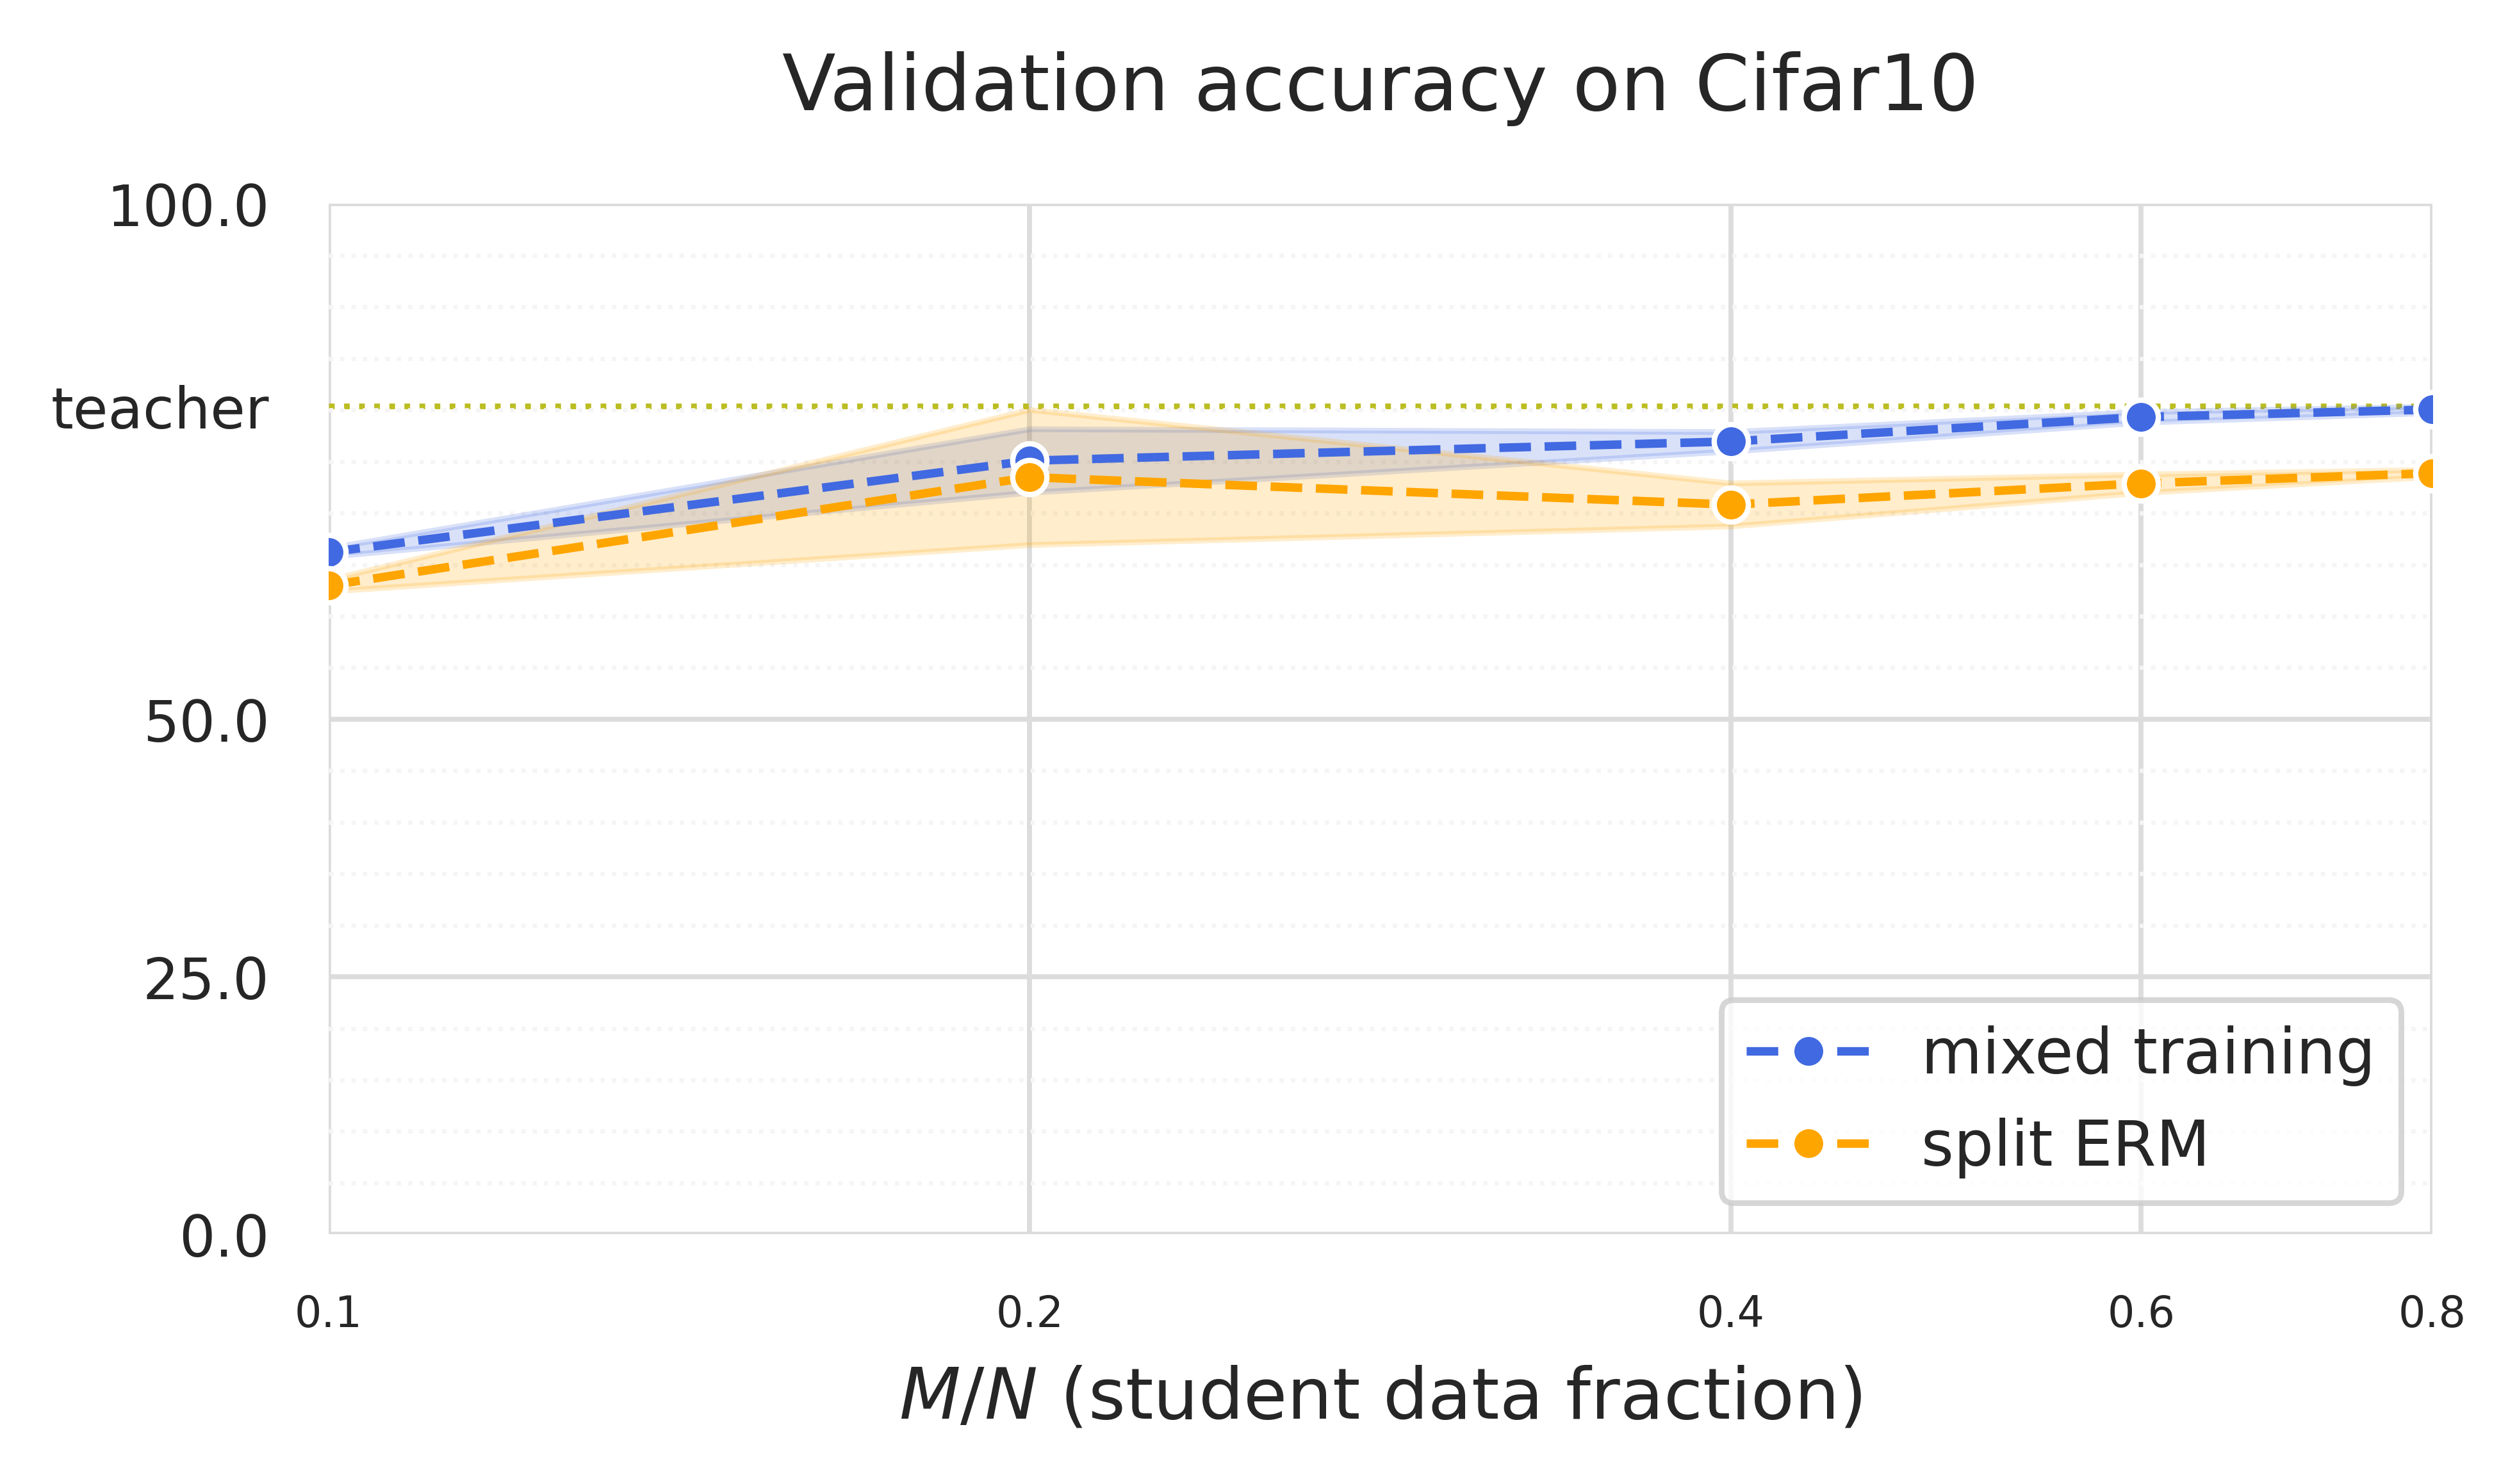

In [13]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,3), sharey=True, dpi=800)
    colors = ['royalblue','orange','dimgray']


    _df = working_df.loc[working_df['teacher_off']==False]
    sns.lineplot(data=_df, x="distil_proportion", y="final_val_acc_S", errorbar="sd",
                 markers=True, marker='o', color=colors[0], ls='--',ax=ax, label="distil.val")
    _df = working_df.loc[working_df['teacher_off']==True]
    sns.lineplot(data=_df, x="distil_proportion", y="final_val_acc_S", errorbar="sd",
                markers=True, marker='o', color=colors[1], ls='--', ax=ax, label="labels.val")
    

    #ax.axvline(100.0, ls='--', color='tab:green')
    # ax.axhline(76.034, ls='--', color=colors[2], label="a")
    # ax.axhline(teacher_train_accuracy, ls='-', color=colors[2], label="b")
    # # props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    # ax.text(0.01, 0.9, 'teacher.val', transform=ax.transAxes, 
    #            fontsize=10, verticalalignment='top', bbox=props)
    #ax.set_xscale('log')
    ax.set_xscale('symlog',linthresh=10e-2)
    ax.set_xlim([0.1,0.4])
    ax.set_ylim([0.0,100.0])

    ax.tick_params(axis='both',  labelsize=9)
    ax.set_xticks(proportions)
    ax.set_xticklabels(proportions, fontsize=6)
    ax.tick_params(axis='x',  rotation=0)

    yticks = [0.0, 25.0, 50.0, teacher_val_accuracy, 100.0]
    plt.yticks(yticks)
    ax.set_yticklabels([0.0, 25.0, 50.0, 'teacher', 100.0], fontsize=8)

    ax.axvline(x=1.0, color='mediumslateblue', linewidth=1.0, linestyle=':')

    # #ax.text(10.0,0, "Local", color="white", bbox={'facecolor': 'tab:green', 'alpha': 0.5, 'pad': 10})
    # ax.set_ylim(-1,10000.0)


    ax.set_title(f"Validation accuracy on Cifar10", fontsize=11, y=1.05)
    ax.set_ylabel(r'', fontsize=11, x=-0.2)
    ax.set_xlabel(r'$M/N$ (student data fraction)', fontsize=10, y=+1)


    #ax[t].legend(title="Eigen-index", loc="upper left")
    # Shrink current axis's height by 10% on the bottom
    
    h, _ = ax.get_legend_handles_labels()
    ax.legend(h, ['mixed training',
                  'split ERM',
                  'teacher (full ERM)'], 
                title="", ncol=1, loc="lower right")


    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    #ax.tick_params(which='minor', bottom=False, left=False)
    #fig.supxlabel(r' % of dataset used', fontsize=12, y=-0.1)

    a = ax.get_ygridlines()
    b = a[3]
    b.set_color('tab:olive')
    b.set_linewidth(0.8)
    b.set_linestyle(':')
    #sns.despine()
    plt.tight_layout()
